In [3]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import matplotlib.pyplot as plt

In [5]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.utils import plot_model

# library to see the progress during the training
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

### environment variables

In [3]:
dataset_images = '/tf/notebooks/captioning_image/Flicker8k_Dataset'
dataset_text = '/tf/notebooks/captioning_image/Flickr8k_text'

In [4]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all images and your respective captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [26]:
def cleaning_text(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            
            img_caption.replace("-", " ")
            desc = img_caption.split()
            
            # convert lowercase
            desc = [word.lower() for word in desc]
            # remove punctuation from words
            desc = [word.translate(table) for word in desc]
            # remove articles
            desc = [word for word in desc if(len(word) > 1)]
            # remove token with numbers
            desc = [word for word in desc if(word.isalpha())]
            
            # convert to a string again
            img_caption = ' '.join(desc)
            captions[img][i] = img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
        
    return vocab

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
dataset_images = '/tf/notebooks/captioning_image/Flicker8k_Dataset'
dataset_text = '/tf/notebooks/captioning_image/Flickr8k_text'

filename = dataset_text + '/Flickr8k.token.txt'

descriptions = all_img_captions(filename)
print('Tamanho da descrição = ', len(descriptions))

# cleaning the description
clean_descriptions = cleaning_text(descriptions)

# building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print('Tamanho do vocabulario = ', len(vocabulary))

save_descriptions(clean_descriptions, 'descriptions.txt')

Tamanho da descrição =  8092
Tamanho do vocabulario =  8763


In [9]:
RESIZED_IMAGE_NUMBER = 224

def extract_features(directory):
    model = ResNet50(include_top=False, pooling='avg')
    features = {}
    
    for img in tqdm(os.listdir(directory)):
        filename = f"{directory}/{img}"
        image = Image.open(filename)
        image = image.resize((RESIZED_IMAGE_NUMBER, RESIZED_IMAGE_NUMBER))
        image = np.expand_dims(image, axis=0)
        # image = preprocess_input(image)
        image = image / 127.5
        image = image - 1.0
        
        feature = model.predict(image)
        features[img] = feature
    
    return features

In [10]:
current_features = extract_features(dataset_images)
dump(current_features, open("features.p", "wb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

### Load features

In [5]:
features = load(open('features.p', 'rb'))

In [6]:
len(features.keys())

8091

In [7]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')[:-1]
    return photos

def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    
    for line in file.split('\n'):
        words = line.split()
        
        if len(words) < 1:
            continue
            
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

def load_features(photos):
    
    all_features = load(open('features.p', 'rb'))
    features = {k:all_features[k] for k in photos}
    return features
    
filename = f'{dataset_text}/Flickr_8k.trainImages.txt'

train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions('descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

### tokenize the descriptions

In [8]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [13]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [30]:
tokenizer.word_index

{'end': 1,
 'start': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'brown': 24,
 'young': 25,
 'red': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'playing': 33,
 'while': 34,
 'down': 35,
 'shirt': 36,
 'ball': 37,
 'standing': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'sitting': 47,
 'front': 48,
 'field': 49,
 'holding': 50,
 'small': 51,
 'yellow': 52,
 'green': 53,
 'group': 54,
 'up': 55,
 'by': 56,
 'large': 57,
 'one': 58,
 'walking': 59,
 'her': 60,
 'men': 61,
 'children': 62,
 'air': 63,
 'into': 64,
 'near': 65,
 'mouth': 66,
 'beach': 67,
 'jumps': 68,
 'runs': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'from': 73,
 'its': 74,
 'riding': 75,


In [9]:
dataset_text = '/tf/notebooks/captioning_image/Flickr8k_text'
filename = dataset_text + '/Flickr8k.token.txt'
descrip = all_img_captions(filename)

def get_max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = get_max_length(descrip)
max_length

38

In [32]:
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(
                tokenizer, 
                max_length, 
                description_list, 
                feature
            )
            yield ((input_image, input_sequence), output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Shape of the input and output
# [a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
# a.shape, b.shape, c.shape

In [33]:
# get model

def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [35]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 50
steps = len(train_descriptions)
# making a directory models to save our models
# os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
model.save("models/model_caption_generator.h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  38
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 38, 256)      1939712     input_18[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 2048)         0           input_17[0][0]     

In [1]:
def extract_features_photo(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((224,224))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
         if index == integer:
             return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text




start man crosses the street end


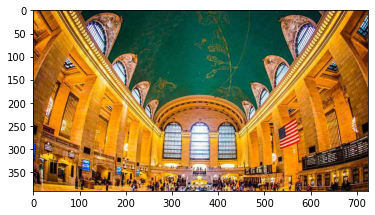

In [6]:
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('model_caption_generator.h5')
resnet_model = ResNet50(include_top=False, pooling='avg')
img_path = 'teste1.jpg'
photo = extract_features_photo(img_path, resnet_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)
img.close()




start man crosses the street end


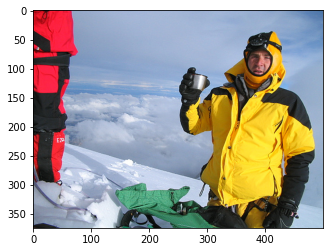

In [43]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('model_caption_generator.h5')
resnet_model = ResNet50(include_top=False, pooling='avg')
img_path = '55470226_52ff517151.jpg'
photo = extract_features(img_path, resnet_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)